# Detect GPU

In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load dataset

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

size=128
batch_size=16

# Load training images
train_ds = image_dataset_from_directory(
    '../chars',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(size, size),
    batch_size=batch_size,
    validation_split=0.3,
    seed=42,
    shuffle=True,
    subset="training",
)

# Load validation images
val_ds = image_dataset_from_directory(
    '../chars',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(size, size),
    batch_size=batch_size,
    validation_split=0.3,
    seed=42,
    shuffle=True,
    subset="validation",
)

Found 15438 files belonging to 62 classes.
Using 10807 files for training.
Found 15438 files belonging to 62 classes.
Using 4631 files for validation.


In [21]:
str(train_ds.class_names)

"['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '97', '98', '99']"

# Training

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
  # MobileNetV2
  MobileNetV2(input_shape=(128, 128, 3),
              include_top=False,
              weights='imagenet',
              pooling='avg'),
  
  # Flatten layer
  Flatten(),

  # Dense layer
  Dense(64, activation='relu', input_dim=1000),
  Dense(128, activation='relu', input_dim=1000),
  Dense(256, activation='relu', input_dim=1000),

  # Output layer
  Dense(62, 'softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall')])

# Callbacks
early_stopping_callback = EarlyStopping(monitor='val_categorical_accuracy',
                         patience=5,
                         min_delta=0.001,
                         mode='max')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/tmp/checkpoint',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/50
 91/676 [===>..........................] - ETA: 24s - loss: 2.6602 - categorical_accuracy: 0.3173 - precision: 0.7913 - recall: 0.1380

KeyboardInterrupt: 

KeyError: "None of [Index(['precision_1', 'val_precision_1'], dtype='object')] are in the [columns]"

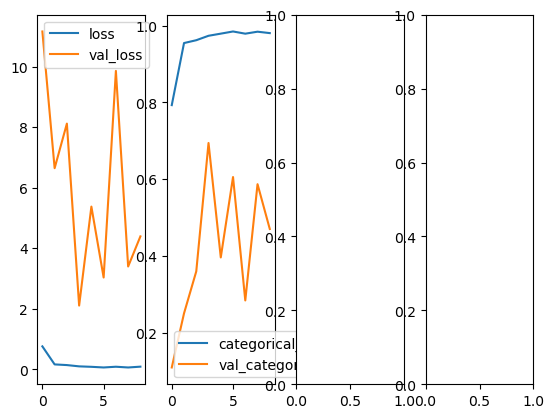

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)

fig, axes = plt.subplots(ncols=4)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[1])
history_frame.loc[:, ['precision', 'val_precision']].plot(ax=axes[2])
history_frame.loc[:, ['recall', 'val_recall']].plot(ax=axes[3])

# Save model

In [17]:
model.save('../models/my_model.h5')